In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from losses import bce_weighted_dice_loss

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import CBAM_R2UNet_v2
from utils import read_tiff, dataset_label_mean
from losses import dice_loss

In [3]:
TEST_IMAGE_PATH = './hupmab_kidney/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './hupmab_kidney/train/aaa6a05cc.json'

test_image = read_tiff(TEST_IMAGE_PATH)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
model.load_state_dict(torch.load('./trained_models/CBAM_R2UNet_v2_Weighted_BCE_Dice_t1000_best_loss.npz'))

<All keys matched successfully>

##### Downsample the image by calculating the mean of 512x512 array (may not need to run)
Compare and observe the difference between original image, downsampled image, and transformed image

In [6]:
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
y=[]
for idx_y in tqdm(range(0, test_image.shape[1], 512)):
    x=[]
    for idx_x in range(0, test_image.shape[2], 512):
        center_x = idx_x + 512 // 2
        center_y = idx_y + 512 // 2
        test_patch = Patch(
            center_x = center_x,
            center_y = center_y,
            theta = 0,
            patch_size = 512,
            glomeruli = test_glomeruli,
            image = test_image
        ).render_image()
        x.append(np.mean(test_patch[0]))
    y.append(x)
my_array = np.array(y)

100%|██████████| 37/37 [00:52<00:00,  1.43s/it]


In [16]:
y=[]
for idx_y in range(my_array.shape[0]):
    x=[]
    for idx_x in range(my_array.shape[1]):
        if my_array[idx_y][idx_x] < 205 and my_array[idx_y][idx_x]>100:
            x.append(255)
        else:
            x.append(0)
    y.append(x)

In [17]:
new_array = np.array(y)

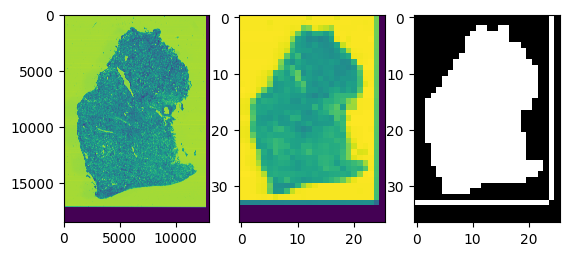

In [18]:
plt.subplot(1,3,1)
plt.imshow(test_image[0])
plt.subplot(1,3,2)
plt.imshow(my_array)
plt.subplot(1,3,3)
plt.imshow(new_array,cmap='grey')
plt.show()

To remove the background, if 100 < value < 205：value=255; else: value = 0.
We will test our model on those white part

### Test model and Visualize


In [5]:
def test(model,test_image,test_glomeruli,image_value_lb = 100,image_value_ub = 205):
    out_img = np.zeros((
        int(np.ceil(test_image.shape[1] / 512) * 512),
        int(np.ceil(test_image.shape[2] / 512) * 512)
    ))
    intersection = 0
    union = 0
    smooth = 0.00000001
    for idx_y in tqdm(range(0, test_image.shape[1], 512)):
        for idx_x in range(0, test_image.shape[2], 512):
            center_x = idx_x + 512 // 2
            center_y = idx_y + 512 // 2
            test_patch = Patch(
                center_x = center_x,
                center_y = center_y,
                theta = 0,
                patch_size = 512,
                glomeruli = test_glomeruli,
                image = test_image
            )
            image = test_patch.render_image()
            label = test_patch.render_mask()
            mean = np.mean(image[0])
            if mean >image_value_ub or mean <image_value_lb:
                continue
            out = model.forward(torch.unsqueeze(torch.tensor(image), 0).type(torch.cuda.FloatTensor))
            out_array = out.cpu().detach().numpy()[0][0]
            intersection += np.sum(out_array * label[0])
            union += np.sum(out_array) + np.sum(label[0])
            out_img[idx_y: idx_y+512, idx_x: idx_x+512] = out_array

    diceLoss = 1 - (2 * intersection + smooth) / (union + smooth)
    print("Dice_loss = ",diceLoss )
    return out_img , diceLoss

In [6]:
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img , diceLoss = test(model,test_image,test_glomeruli)

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [03:12<00:00,  5.20s/it]

Dice_loss =  0.7495602730659197


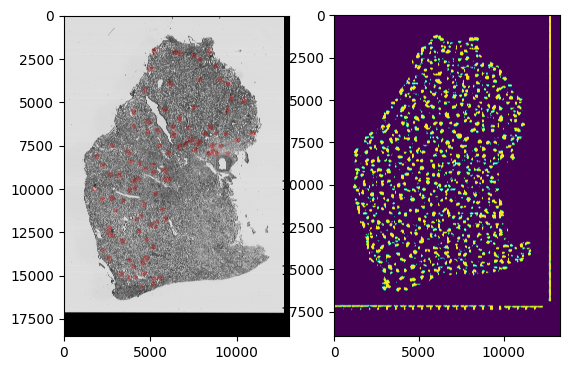

In [7]:
import json
from matplotlib.patches import Polygon
plt.subplot(1, 2, 1)
# Load label path from json file
kidney_label = json.load(open(TEST_LABEL_PATH))
for element in kidney_label:
    if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
        label = element['geometry']
        if label['type'] == 'Polygon':
            coordinates = label['coordinates'][0]

            # Create polygon from label coordinates and plot
            label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)
            ax = plt.gca()
            ax.add_patch(label_polygon)

imgplot = plt.imshow(test_image[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.show()

In [43]:
centroid = []
for i in range(len(test_glomeruli)):
    x = test_glomeruli[i].centroid_x//512
    y = test_glomeruli[i].centroid_y//512
    centroid.append([x,y])

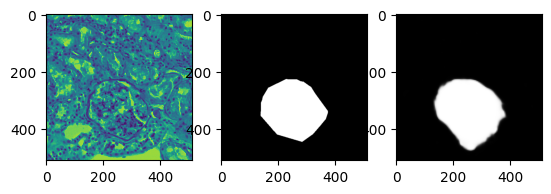

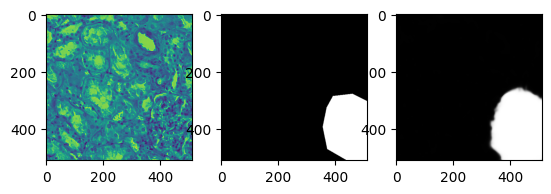

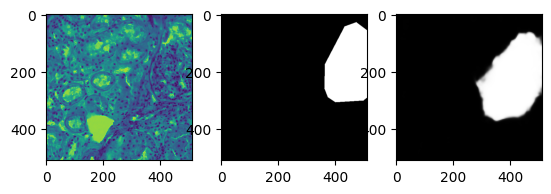

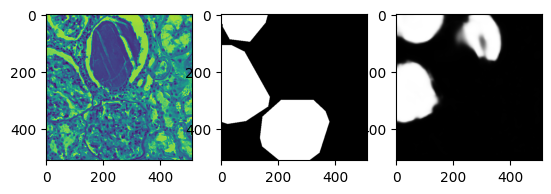

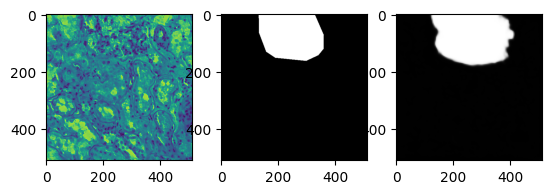

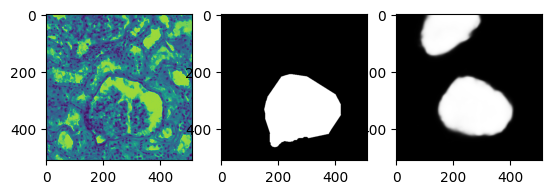

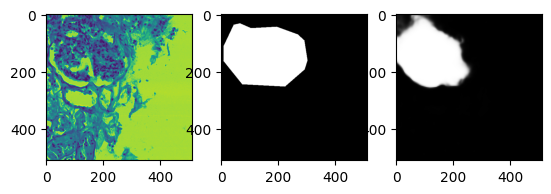

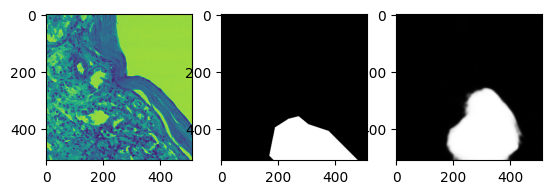

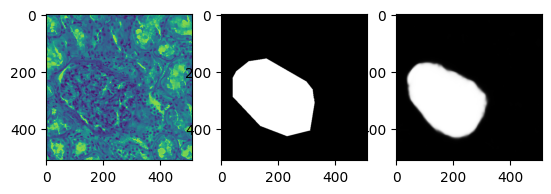

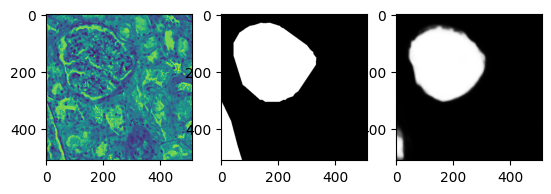

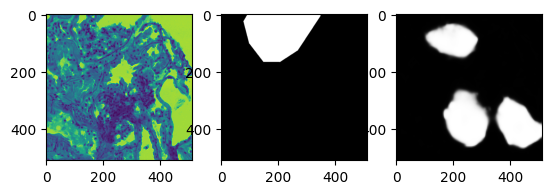

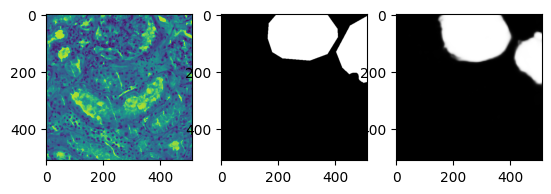

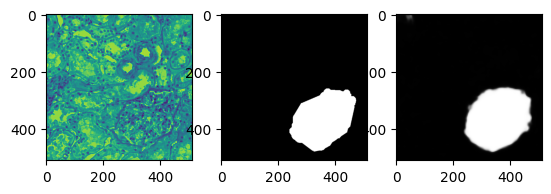

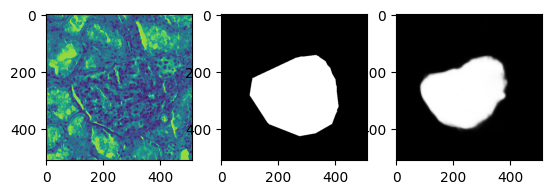

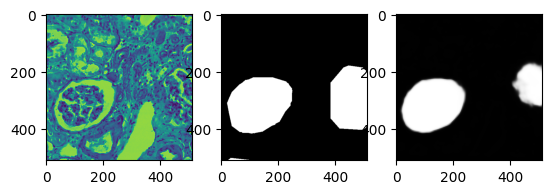

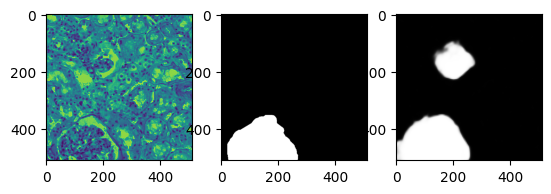

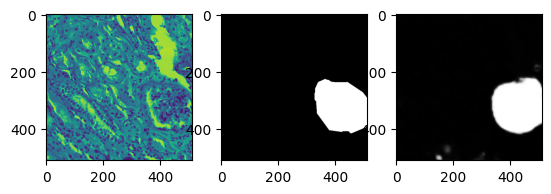

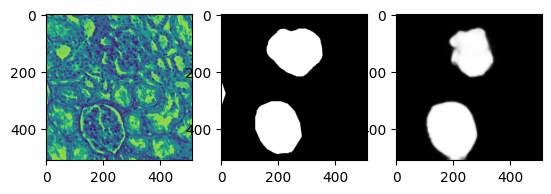

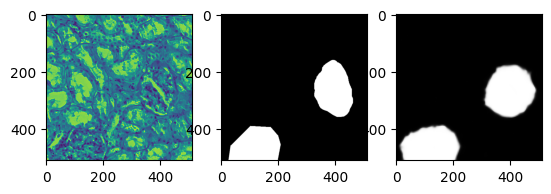

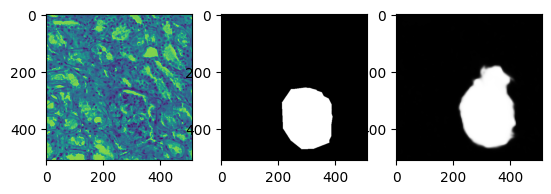

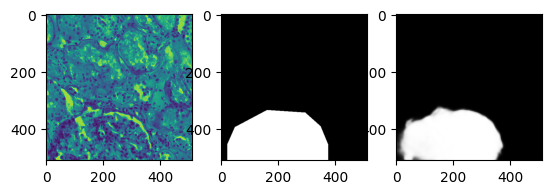

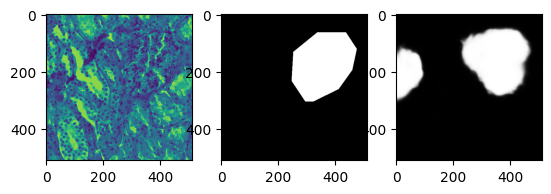

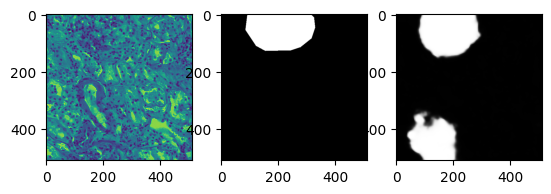

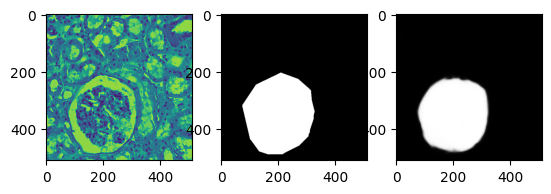

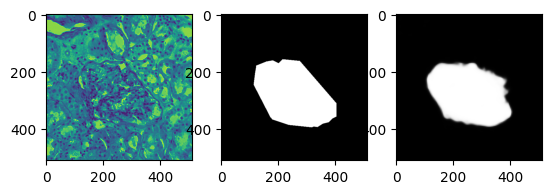

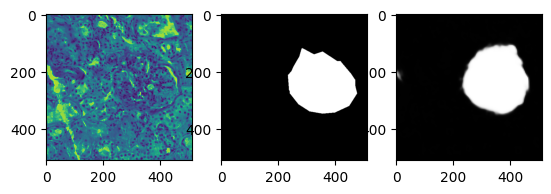

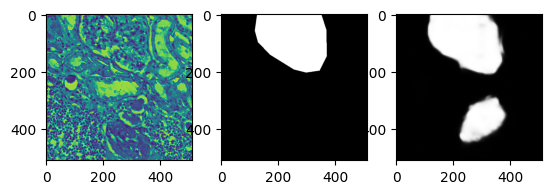

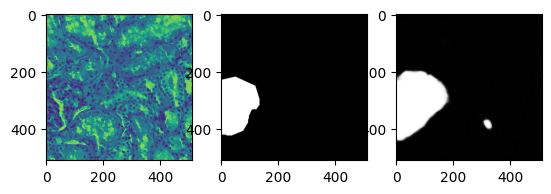

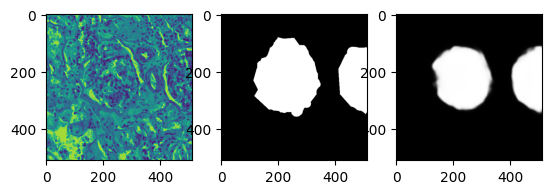

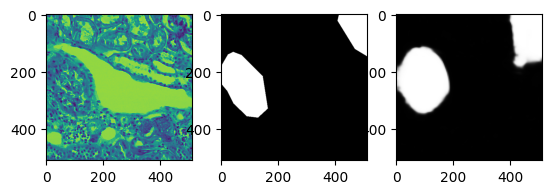

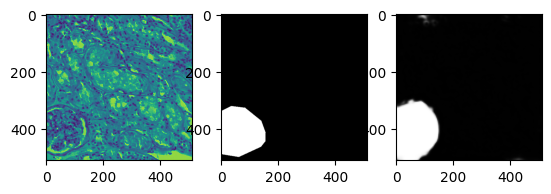

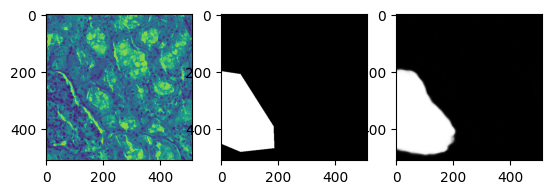

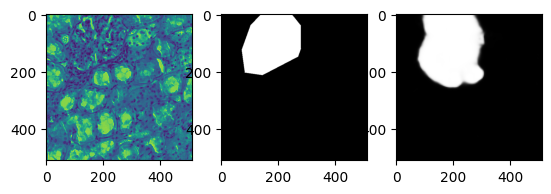

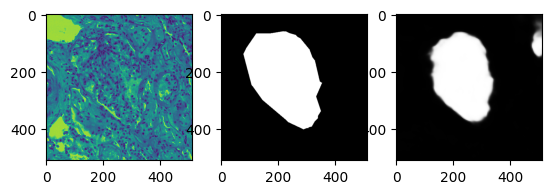

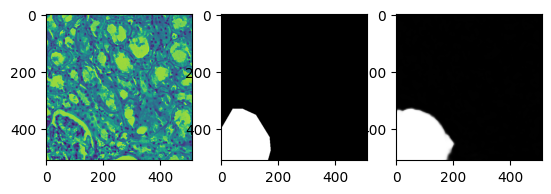

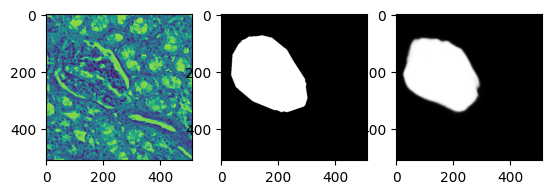

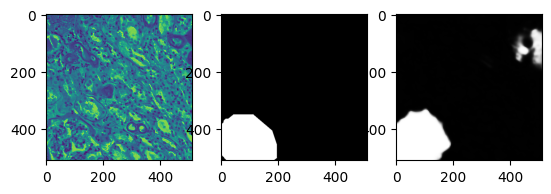

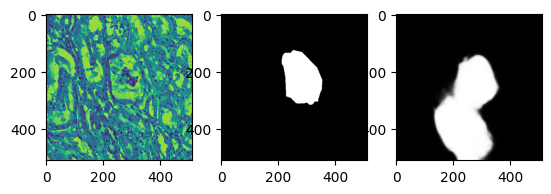

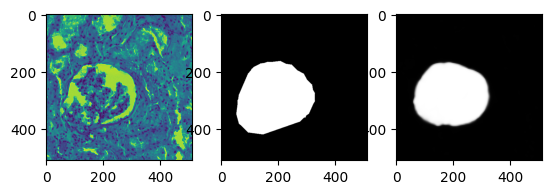

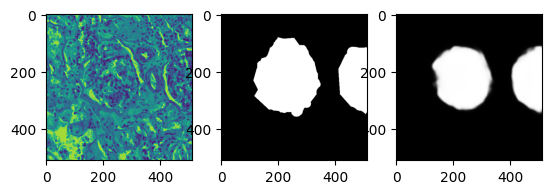

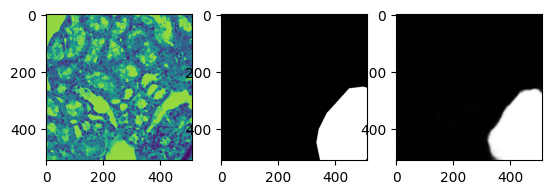

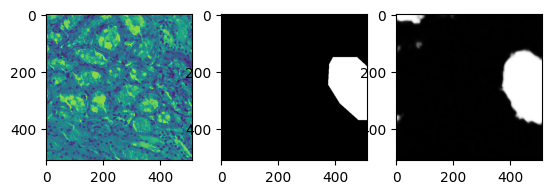

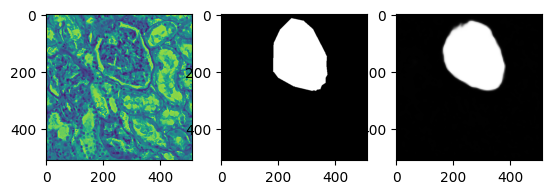

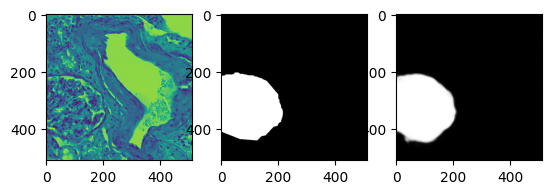

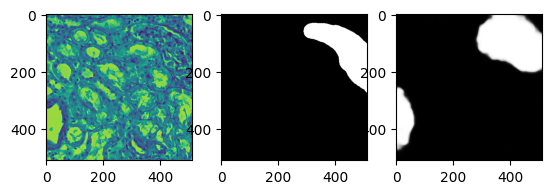

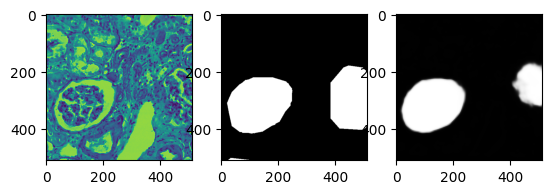

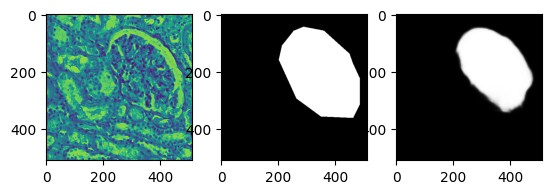

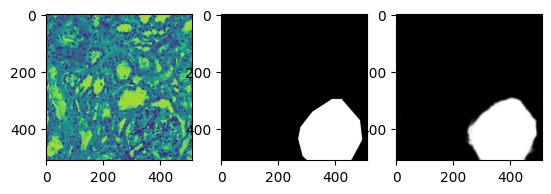

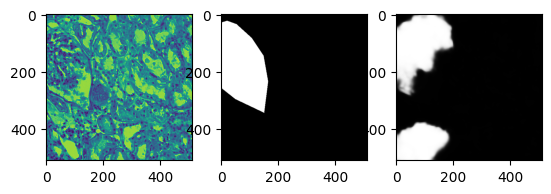

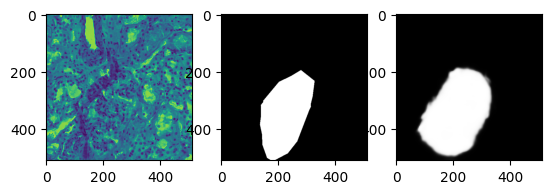

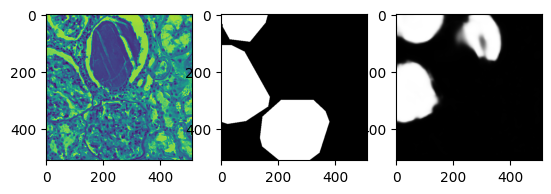

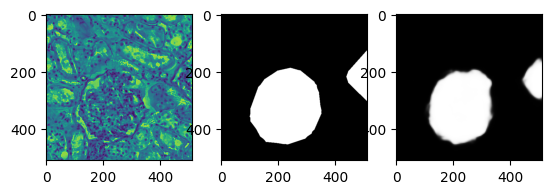

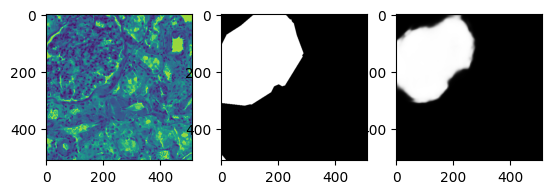

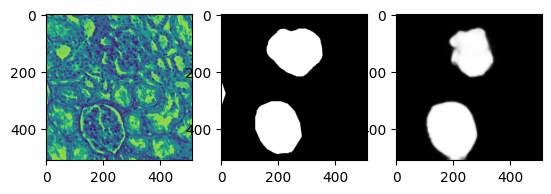

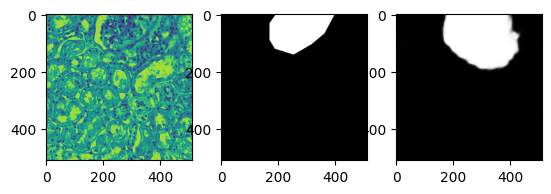

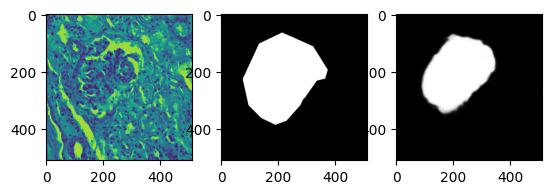

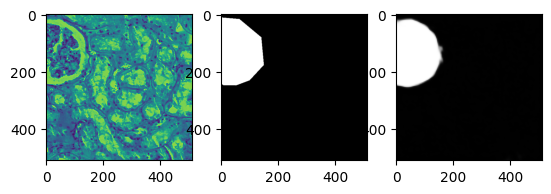

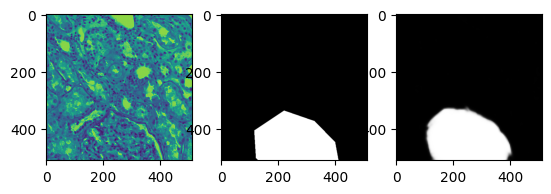

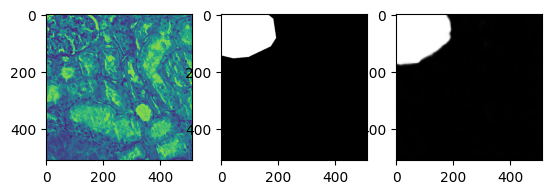

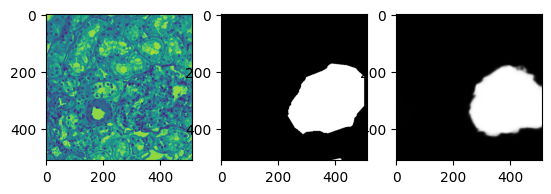

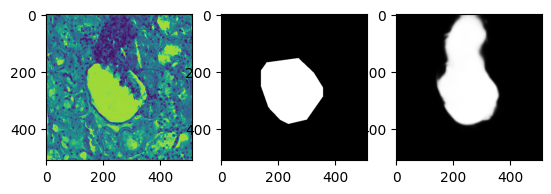

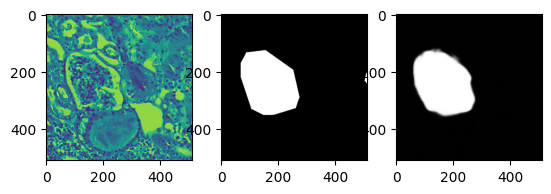

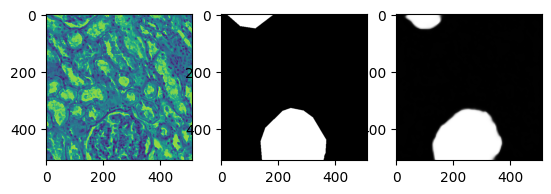

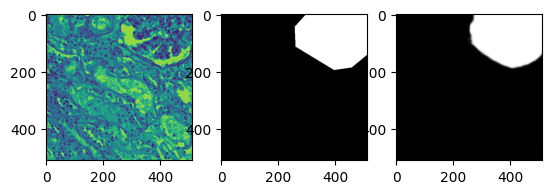

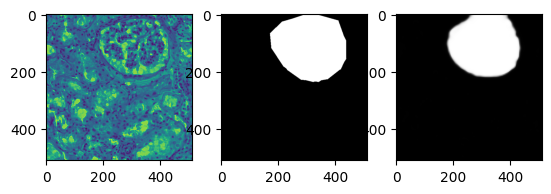

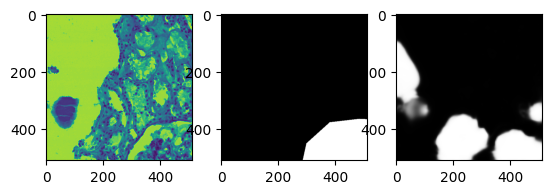

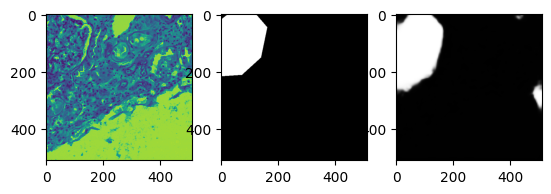

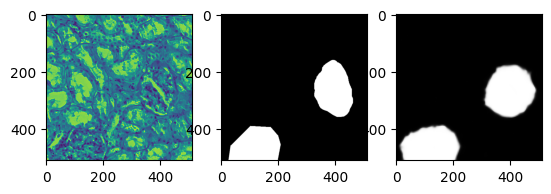

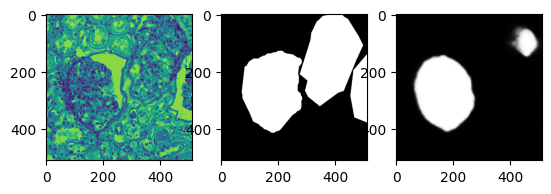

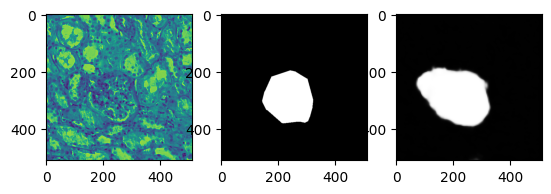

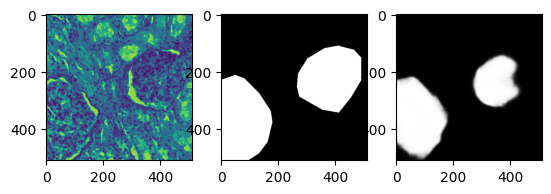

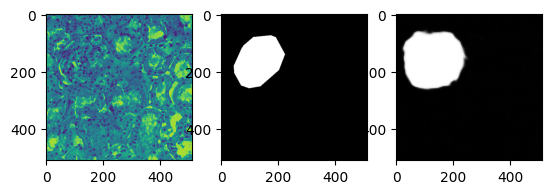

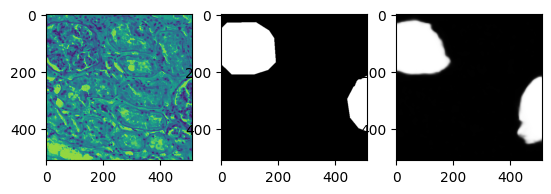

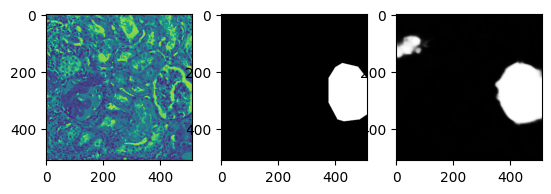

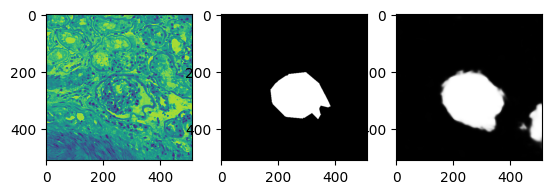

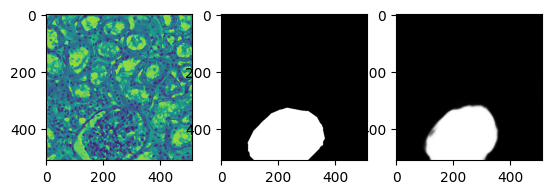

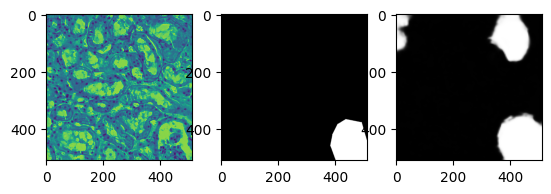

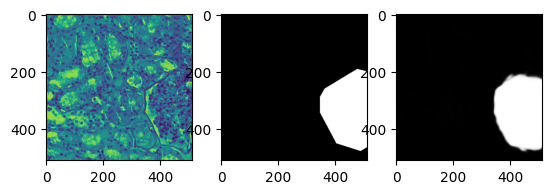

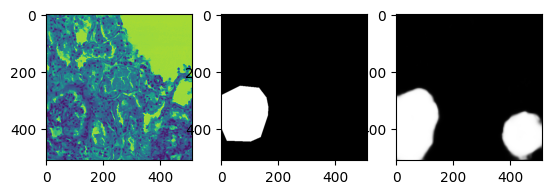

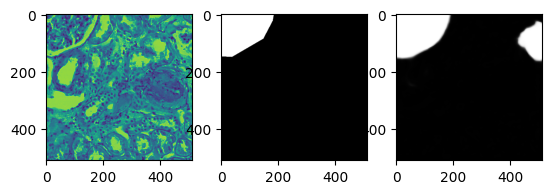

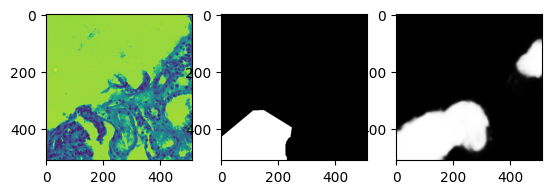

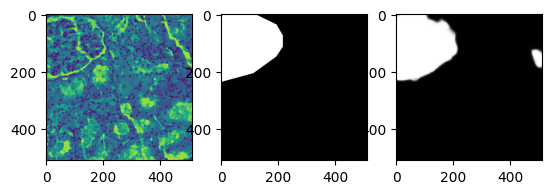

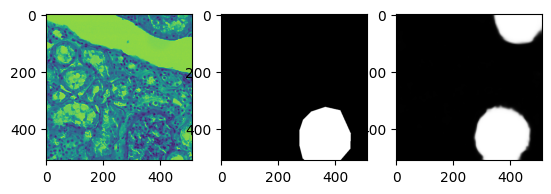

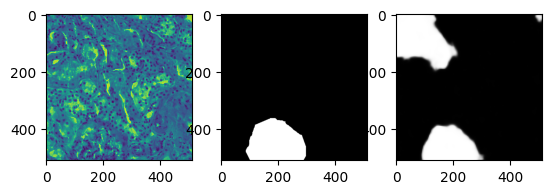

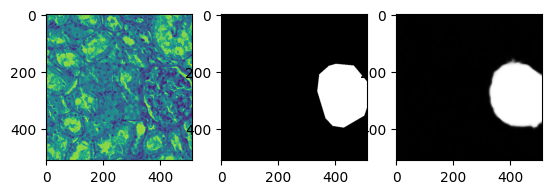

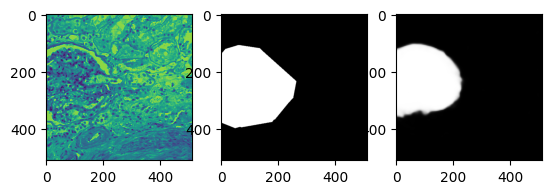

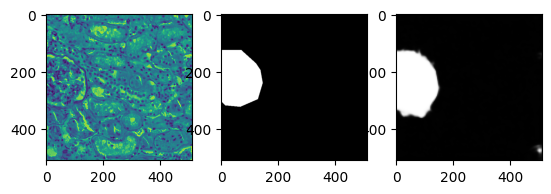

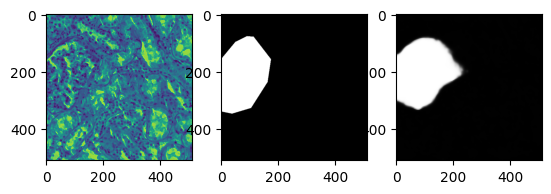

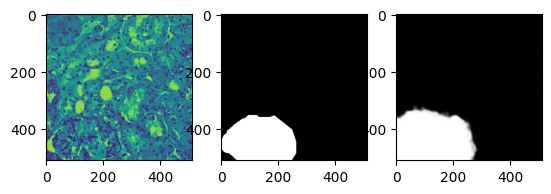

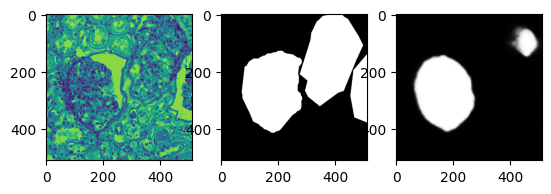

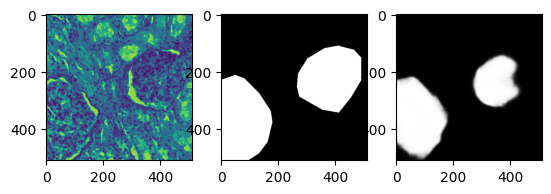

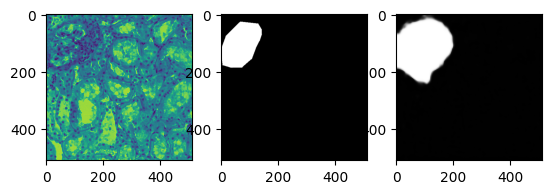

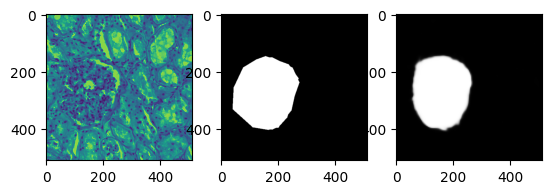

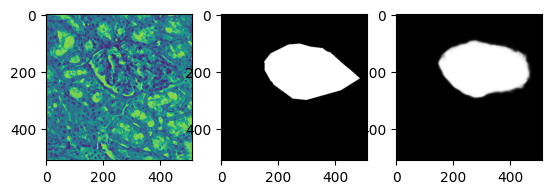

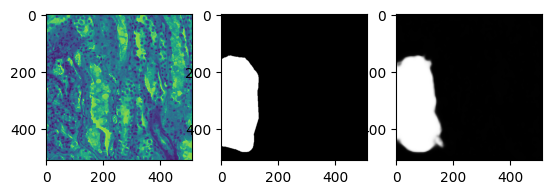

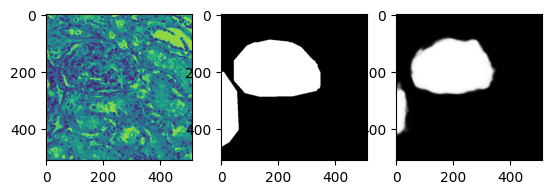

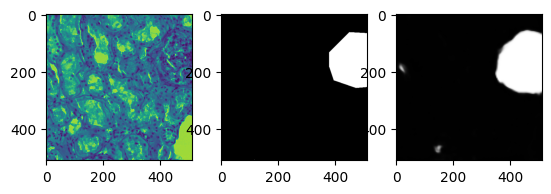

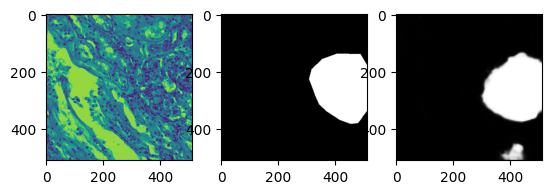

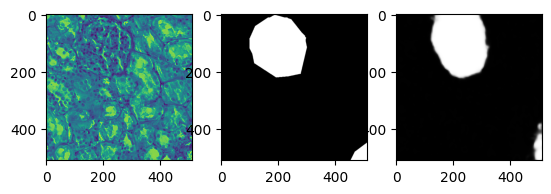

In [57]:
#len(centroid) = 99
for centroid_idx in range(99):
    idx_x = centroid[centroid_idx][0]
    idx_y = centroid[centroid_idx][1]
    center_x = idx_x*512 + 512 // 2
    center_y = idx_y*512 + 512 // 2
    test_patch = Patch(
        center_x = center_x,
        center_y = center_y,
        theta = 0,
        patch_size = 512,
        glomeruli = test_glomeruli,
        image = test_image
    ).render_image()

    test_mask = Patch(
        center_x = center_x,
        center_y = center_y,
        theta = 0,
        patch_size = 512,
        glomeruli = test_glomeruli,
        image = test_image
    ).render_mask()
    out = model.forward(torch.unsqueeze(torch.tensor(test_patch), 0).type(torch.cuda.FloatTensor))

    plt.subplot(1,3,1)
    plt.imshow(test_patch[0])
    plt.subplot(1,3,2)
    plt.imshow(test_mask[0],cmap='grey')
    plt.subplot(1,3,3)
    plt.imshow(out.cpu().detach().numpy()[0][0],cmap='grey')
    plt.show()

In [51]:
int(np.ceil(test_image.shape[1] / 512) * 512)

18944

In [48]:
test_image.shape[1]

18484

In [59]:
out_img[0: 0+512, 0: 0+512].shape

(512, 512)

In [110]:
import random
def generate_random_patches(patch_size, num_patches, glomeruli, image):
    patches = []
    for _ in tqdm(range(num_patches)):
        glomeruli_num = len(glomeruli)
        glomerulus = glomeruli[random.randrange(0, glomeruli_num)]
        
        center_x = random.randrange(
            patch_size // 2,
            image.shape[2] - patch_size // 2
        )
        
        center_y = random.randrange(
            patch_size // 2,
            image.shape[1] - patch_size // 2
        )
        
        theta = random.random()*360
        
        patches.append(Patch(
            center_x = center_x,
            center_y = center_y,
            theta = theta,
            patch_size = patch_size,
            glomeruli = glomeruli,
            image = image
        ))
    return patches

  0%|          | 0/100 [00:00<?, ?it/s]

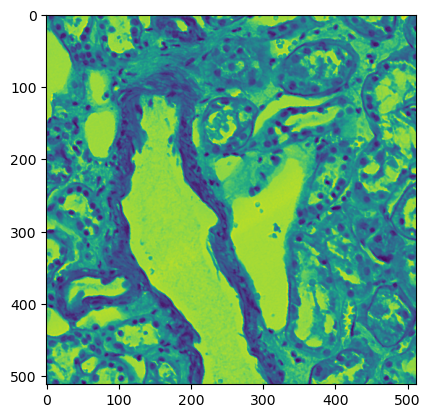

In [111]:
test_patches = generate_random_patches(
    patch_size = 512,
    num_patches = 100,
    glomeruli = test_glomeruli,
    image = test_image
)

for patch in test_patches:
    patch.render_image()
plt.imshow(test_patches[4].render_image()[0])

In [104]:
test_patches[2].center_x
# test_patches[2].center_y

4683

In [85]:
Patch(
    center_x = 14759,
    center_y = 8436,
    theta = 0,
    patch_size = 512,
    glomeruli = test_glomeruli,
    image = test_image
).render_image()

ValueError: could not broadcast input array from shape (1,1452,0) into shape (1,1452,431)

In [107]:
test_patches[4].center_x

15476